<img src="../images/galvanize-mdh.png" alt="galvanize-mdh" align="center" style="width: 200px;"/>

<hr />

### Leveraging Data Science (During COVID-19) 

Two examples using probabilistic programming.

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import arviz as az

from IPython.display import HTML, display

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

SMALL_SIZE = 15
MEDIUM_SIZE = 16
LARGE_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title


%load_ext autoreload
from covidhelp import *
%autoreload 2

%matplotlib inline
%precision 4
plt.style.use('dark_background')

Disclaimer:
    
Although these examples are related to COVID-19, neither I nor the organizations I am associated with are disease experts and we are not responsible for how this information is used.  This post is meant to demonstrate how to inform decision making with probabilistic programming. We use COVID-19 related examples in order to keep this work relevant to problems companies face today.  

## Overview

* INTRO: Brief introduction to Probabilistic Programming and Bayesian Statistics

* EXAMPLE I: Which sales representative should take a plane?

* EXAMPLE II: A case study on supply chain optimization

Read the objectives

## Introduction

* The majority of data science being applied in industry is <font style="color:blue">supervised learning</font>
* Supervised learning yields predictions, but translating predictions into business decisions can be difficult
* We are going to use a <font style="color:blue">Bayesian model</font> to inform decision making

Some of the reasons to consider the Bayesian approaches are that:

* We can find these best decisions over the range of possible scenarios 
* In this framework we can communicate results in the language business cares about

Some supervision learning offers insights into the importance of predictors depending on the model

## Bayesian Statistics


### Why you might want to use probabilistic programming
* <font style="color:blue">Customization</font> - We can create models that have built-in hypothesis tests
* <font style="color:blue">Propagation of uncertainty</font> - There is a degree of belief associated prediction and estimation
* <font style="color:blue">Intuition</font> - The models are essentially 'white-box' which provides insight into our data
* <font style="color:blue">Priors</font> - Offer both a way to include business knowledge and naturally update our degree of belief with new data

### There is no free lunch

* <p style="color:blue">Deep dive</p> - Generally requires a fairly deep understanding of statistics
* <p style="color:blue">Overhead</p> - Computational overhead might make it difficult to be production ready
* <p style="color:blue">Sometimes simple is enough</p> - The ability to customize models in almost a plug-n-play manner has to come with some cost. 


notes

## Bayes Formula


* $x$ - data
* $\theta$ - unknown quantities that we care about

$$
P(\theta|x) \propto \prod^{N}_{i=1} P(x_{i}|\theta)P(\theta)
$$

* <p style="color:blue">Posterior</p> 
  $P(\theta|x)$ - What we know about our unknowns having observed some data
* <p style="color:blue">Prior</p>
  $P(\theta)$ - Information that we have about our unknowns before we look at the data
* <p style="color:blue">Likelihood</p> 
  $P(x_{i}|\theta)$  - Probability distribution used to integrate data into our posterior

The posterior is what we know about theta after having observed y.  When Bayes formula is expressed in this form we see that the posterior is proportional to the likelihood time the prior.  That means they are equal to each other up to a constant.

## Example I - Which sales representative should travel?

Let's start with a simple example

If we wanted to model whether a deal will be signed or not signed based on a sales funnel a simple approach could be to use a Binomial distribution.  There is a parameter $p$ that governs the proportion of signed deals.

> It is a way to model a series of coin flips

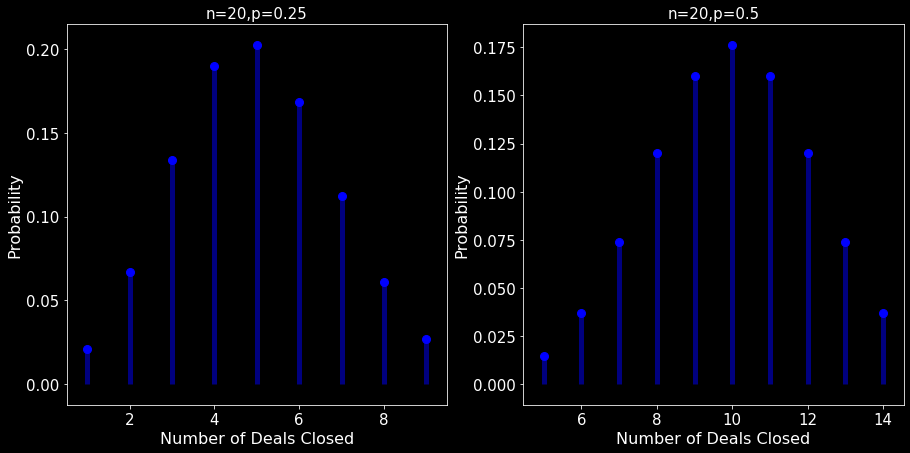

In [2]:
fig = plt.figure(figsize=(15,8))
axes = plot_example_binomial([(20,0.25),(20,0.5)],fig=fig)

logp = -15.064, ||grad|| = 25: 100%|██████████| 7/7 [00:00<00:00, 2522.78it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:00<00:00, 8845.22draws/s]
The number of effective samples is smaller than 25% for some parameters.


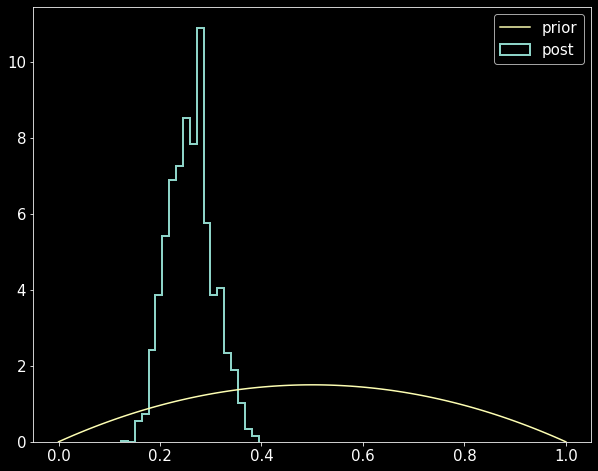

In [3]:
num_deals,deals_signed = 100,25          # data: the total number of deals and the number of deals closed 
alpha,beta = 2,2                         # prior: beta takes two positive shape parameters 

trace = run_binomial_model(num_deals,deals_signed,alpha,beta)
ax = plot_binomial_model(trace, alpha, beta)

Maybe you want to make an informed decision about who should travel to make this deal.  You could look at a plot

In [22]:
def compare_sales_reps():
    alpha,beta = 2,2 
    traces = []
    subplot = 0
    for num_deals, deals_signed in [(100,25),(45,22),(75,11)]:    
        # context management
        with pm.Model() as model: 
            p = pm.Beta('p', alpha=alpha, beta=beta)
            y = pm.Binomial('y', n=num_deals, p=p, observed=deals_signed)

            start = pm.find_MAP()
            step = pm.Metropolis()
            trace = pm.sample(1000, step, start)
        
        traces.append(trace)
      
    return(traces)

traces = compare_sales_reps()

logp = -15.064, ||grad|| = 25: 100%|██████████| 7/7 [00:00<00:00, 3154.63it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:00<00:00, 7167.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
logp = -1.7401, ||grad|| = 0.5: 100%|██████████| 5/5 [00:00<00:00, 3037.15it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:00<00:00, 7854.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
logp = -22.361, ||grad|| = 26.5: 100%|██████████| 8/8 [00:00<00:00, 2547.02it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:00<00:00, 7480.74draws/s]
The number of effective samples is smaller than 25% for some parameters.


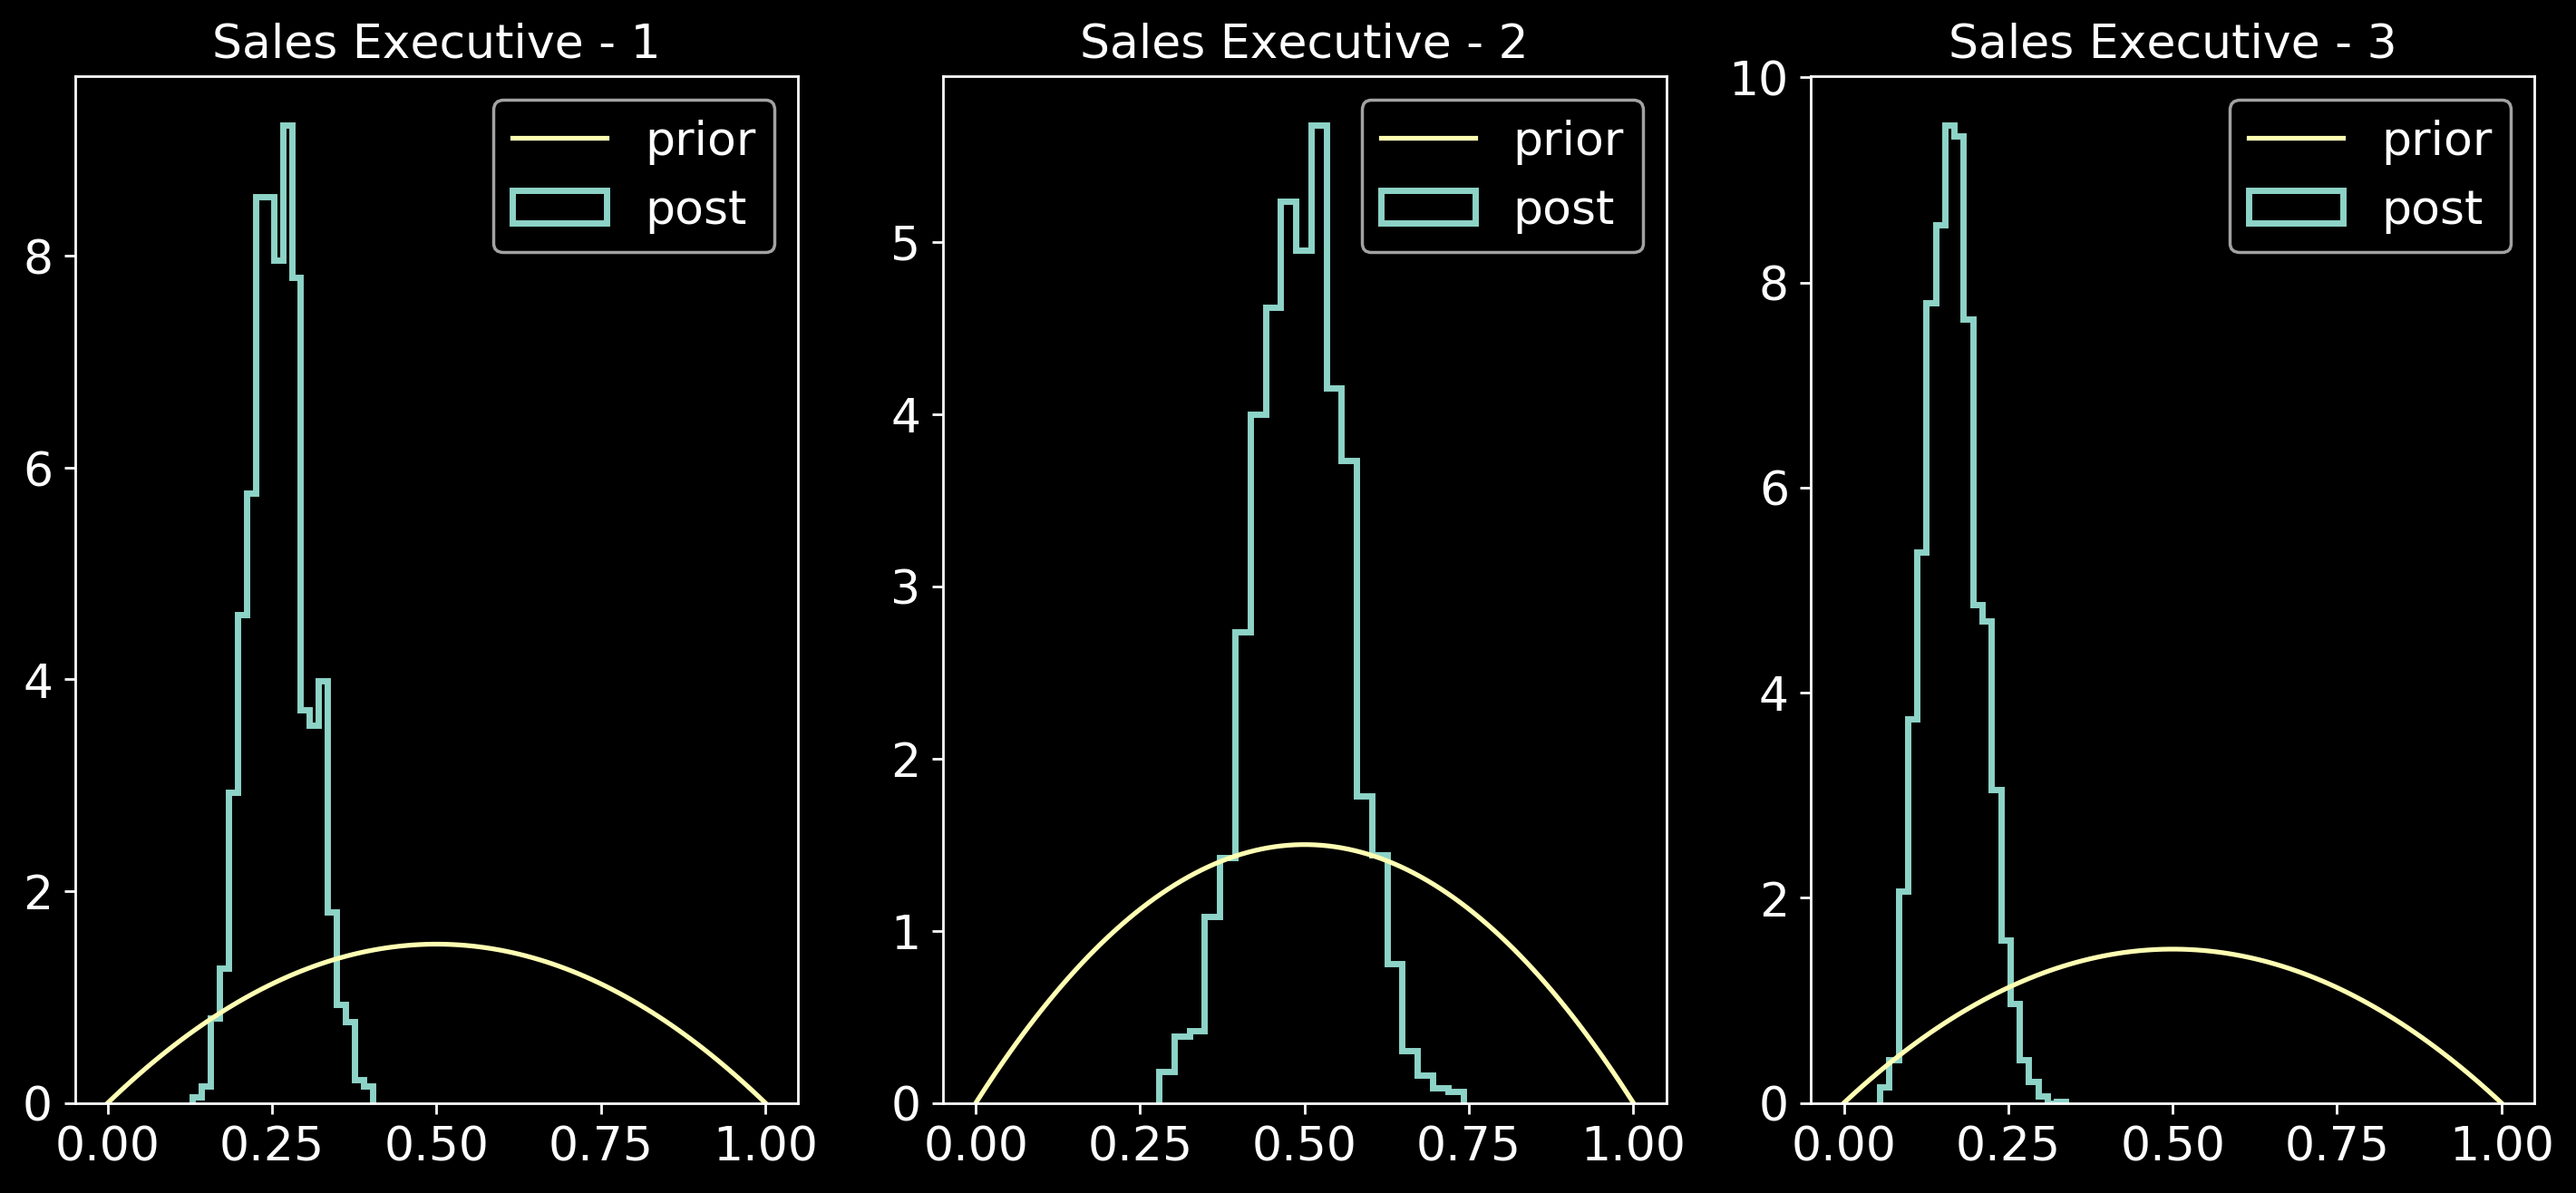

In [23]:
def plot_sales_reps():
    fig = plt.figure(figsize=(14,6),dpi=250)
    subplot = 0
    for i, args in enumerate([(100,25),(45,22),(75,11)]):
        num_deals, deals_signed = args
        subplot +=1
        ax = fig.add_subplot(1,3,subplot)
        
        trace = traces[i]
        
        ax = plot_binomial_model(trace, alpha, beta, ax=ax);
        ax.set_title("Sales Executive - {}".format(subplot))
    
plot_sales_reps()

So we could use this plot to help figure out who to send if we only wanted to consider past sales performance to make the decision.

In [41]:
#fig = plt.figure(figsize=(14,6),dpi=250)

data_mu = [t['p'].mean() for t in traces]
data_std = [t['p'].std() for t in traces] 

factor1 = [1.0,0.1]
factor2 = [2.0,0.2]
factor3 = [3.0,0.3]

mu_prior = 0.5
std_prior =  0.01
with pm.Model() as model:
    true_risk = pm.Normal("true_risk", mu=mu_prior, sd=std_prior)
    
    factor_1 = pm.Normal("factor 1", mu=factor1[0], sd=factor1[1])
    factor_2 = pm.Normal("factor 2", mu=factor2[0], sd=factor2[1])
    factor_3 = pm.Normal("factor 3", mu=factor3[0], sd=factor3[1])
    risk_estimate = factor1 + factor2 + factor3
    
    logp = pm.Normal.dist(mu=risk_estimate, sd=(3e3)).logp(true_risk)
    error = pm.Potential("error", logp)
    
    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]

price_trace = burned_trace["true_risk"]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [factor 3]
>Metropolis: [factor 2]
>Metropolis: [factor 1]
>Metropolis: [true_risk]
Sampling 4 chains, 0 divergences: 100%|██████████| 202000/202000 [00:43<00:00, 4667.35draws/s]
The number of effective samples is smaller than 10% for some parameters.


/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[

minimum at risk 1: 50.00
minimum at risk 20: 50.00


/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


minimum at risk 40: 50.00
minimum at risk 60: 50.00


/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


minimum at risk 80: 50.00
minimum at risk 100: 50.00


/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


Text(0, 0.5, 'expected risk')

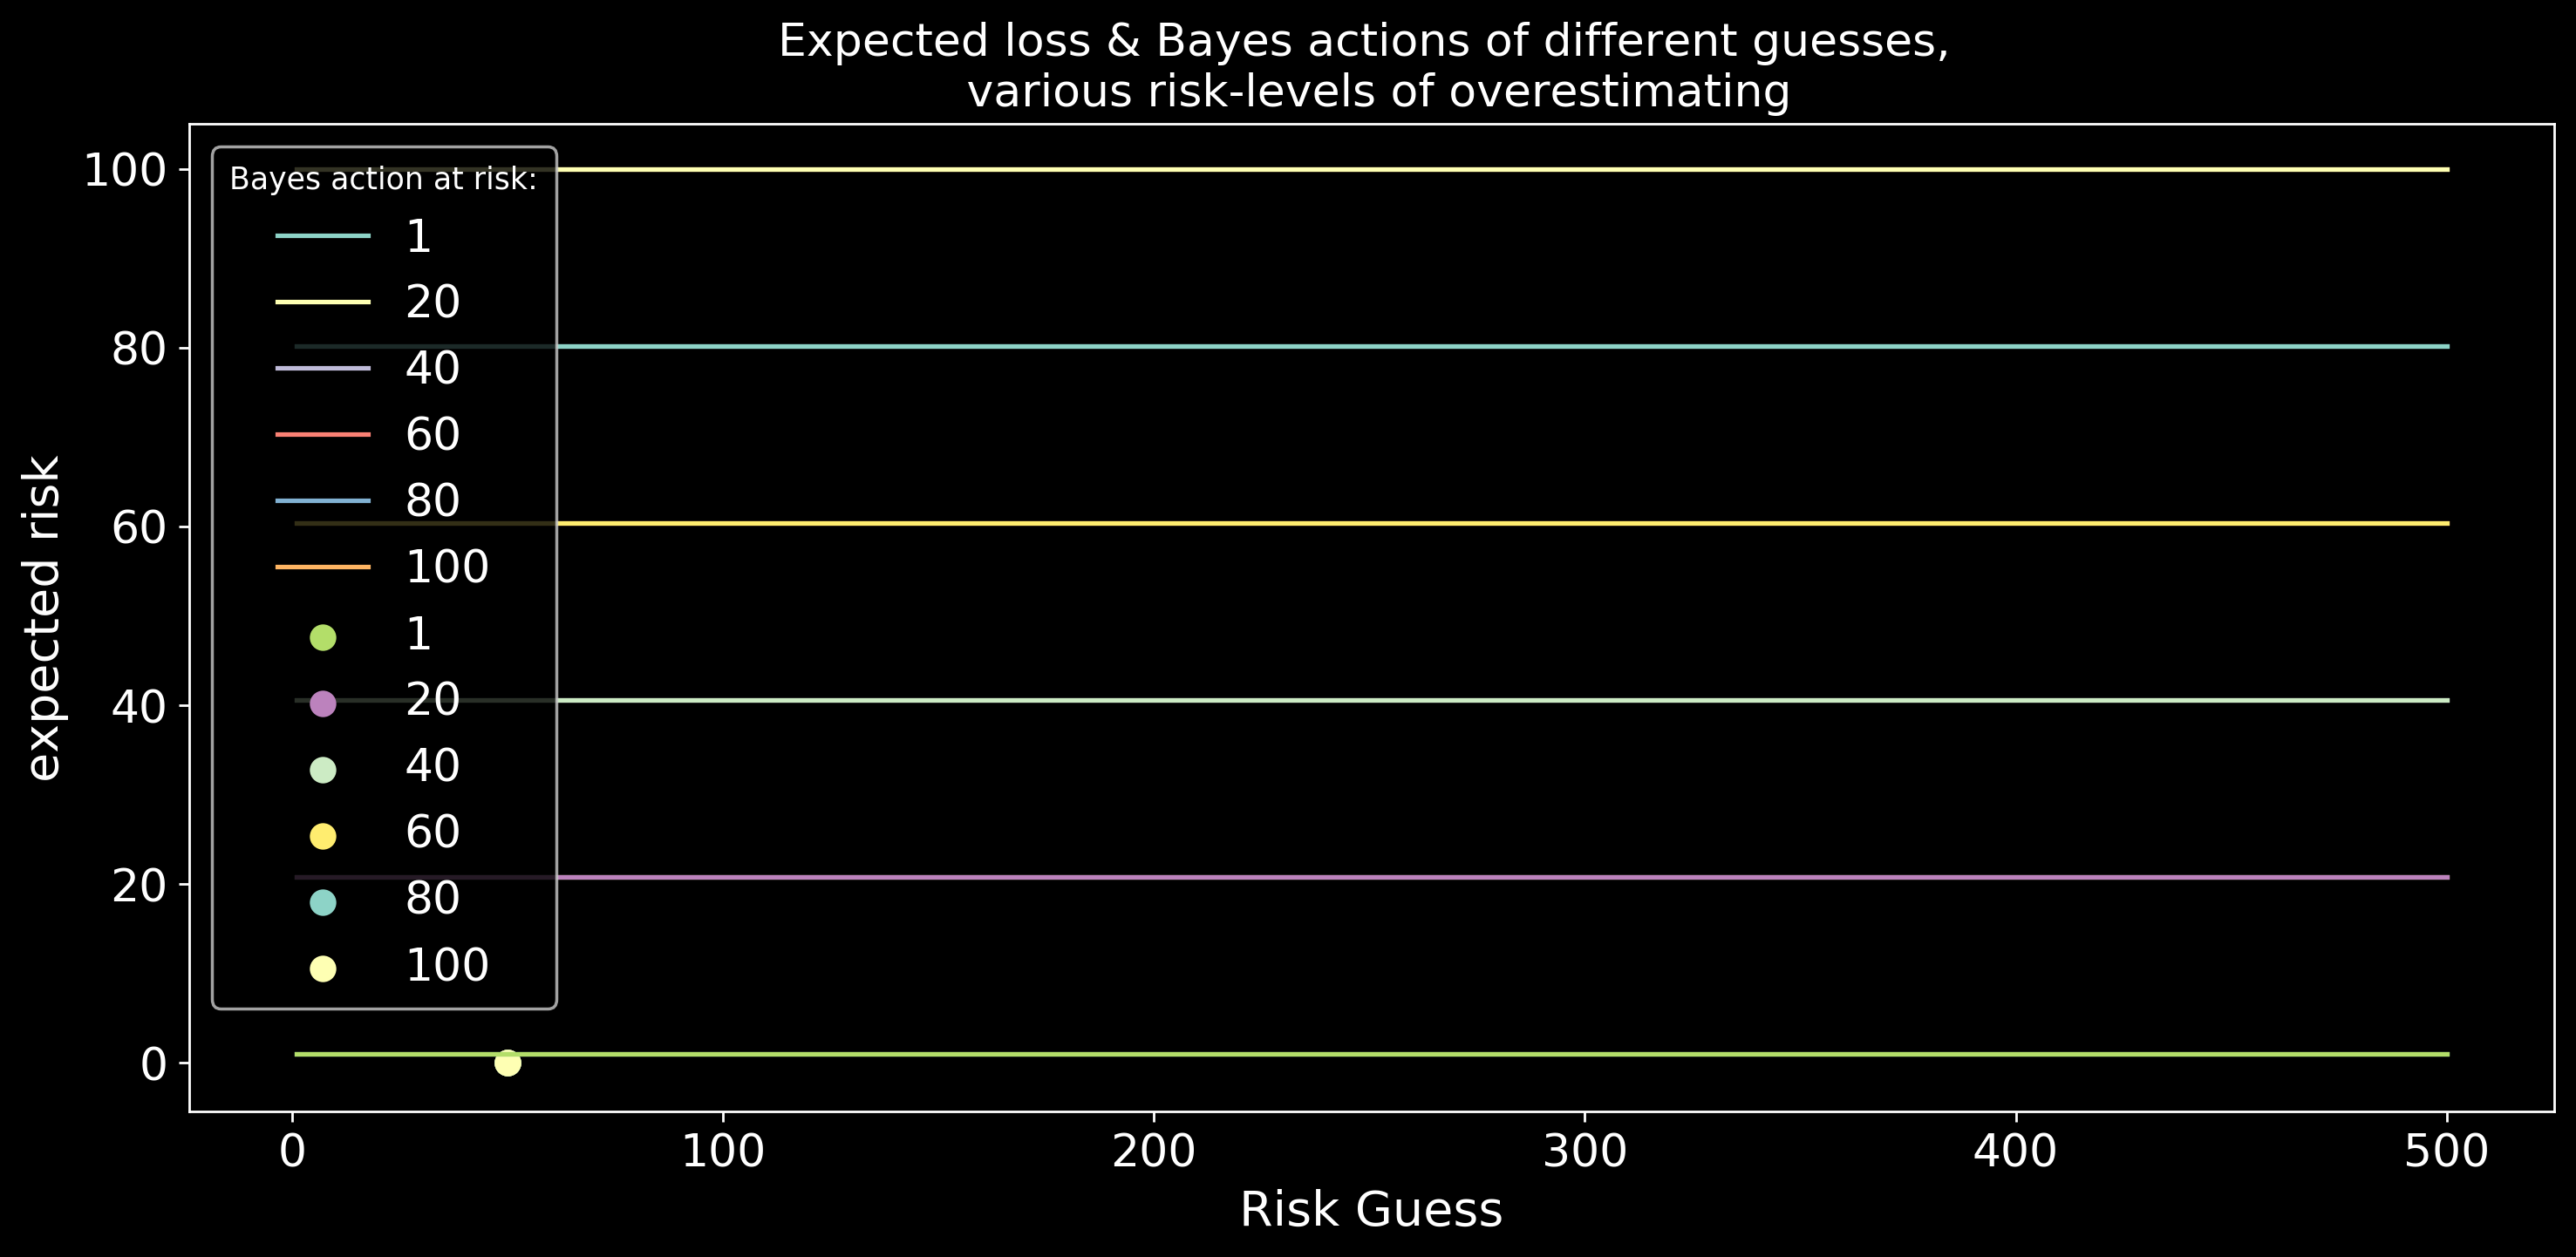

In [37]:
import scipy.optimize as sop


fig = plt.figure(figsize=(14,6),dpi=250)
ax = plt.subplot(111)


def showdown_loss(guess, true_price, risk = 10):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = [abs(true_price - guess) <= 250]
        loss[close_mask] = -2*true_price[close_mask]
        loss[ix] = risk
        return loss


guesses = np.linspace(1, 500, 70) 
risks = np.linspace(1, 100, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()
        
for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label = "%d"%_p)
    
plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
#plt.xlim(5000, 30000);


for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 50, args=(_p,),disp = False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results , color = _color['color'])
    plt.scatter(_min_results, 0, s = 60, \
                color= _color['color'], label = "%d"%_p)
    #plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))
                                    
plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints = 1, title = "Bayes action at risk:")
plt.xlabel("Risk Guess")
plt.ylabel("expected risk")
#plt.xlim(7000, 30000)
#plt.ylim(-1000, 80000);

## Example II - Supply Chain Optimization

### Let's start with a fictional consulting business (Ummon)

* Growing a consulting business has many similarities to a supply chain
* The firm had seen exceptional growth until COVID-19
* Things are starting to pick-up again
* Looking for a competitive edge when things are at the new normal

<p style="color:blue">Business Opportunity</p>

> During last phase of growth there were mistakes made and they are looking use data to better optimize the supply chain that is used to staff teams

## Ummon's Data


While the consultants themselves are reusable, we still need new team members for every engagement because we are assuming some positive amount of company growth.  

* There are three suppliers we can source talented consultants from
* These suppliers have:

   * different prices
   * different quality outcomes
   * different maximum amounts they can provide within a certain timeframe  

We know the prices and order sizes, but the true yield distribution is unobserverable.

### Step 1: Estimating Supplier yields

We assume suppliers yield are unknown so we have to estimate them from previous batches ordered.

* The yield represents the percentage of consultants that pass our assessment process
* Due to different *training processes*, the yield varies quite a bit (also reflected in the price)
* Also we assume we have ordered different numbers of time from different suppliers

In [5]:
SUPPLIER_YIELD = np.array([.9, .5, .8])    # unknown
SUPPLIER_YIELD_SD = np.array([.1, .2, .2]) # unknown
PRICES = [5000.0, 1000.0, 4000.0]          # known
MAX_ORDER_SIZE = [100, 80, 100]            # known
N_OBS = [30, 20, 2]                        # number of orders from each supplier   

notes


## Supplier Yield Data

In [6]:
np.random.seed(100)
data = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=n_obs).random())
    
data_df = pd.DataFrame(data).T
data_df
data_df.columns = ["supplier-0","supplier-1","supplier-2"]
data_df.describe()

,supplier-0,supplier-1,supplier-2
count,30.000000,20.000000,2.000000
mean,0.918735,0.558903,0.896244
std,0.080713,0.208598,0.005410
min,0.661303,0.086342,0.892419
25%,0.868581,0.483706,0.894331
50%,0.955156,0.604465,0.896244
75%,0.979414,0.686848,0.898157
max,0.999139,0.854822,0.900070


notes

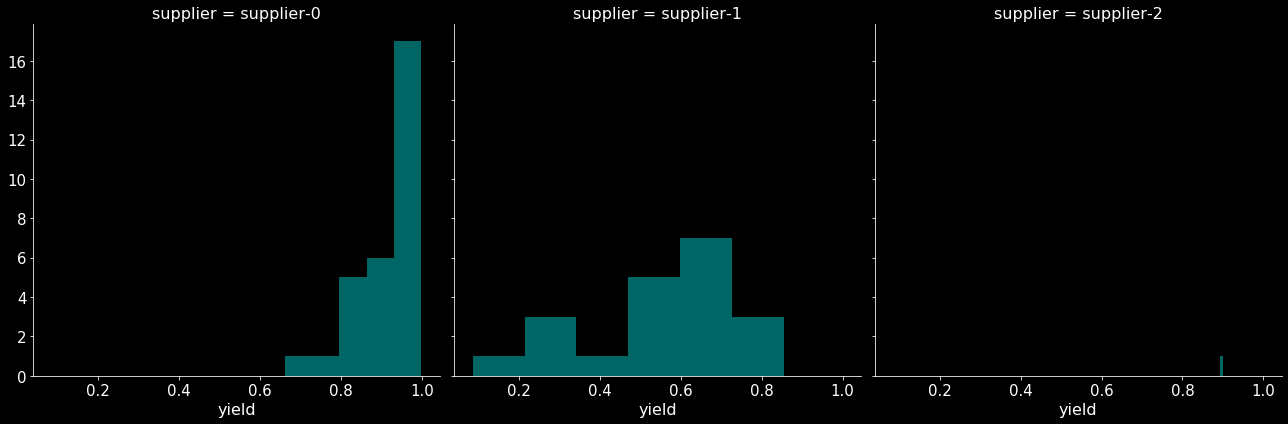

In [7]:
def plot_yield_data(data_df):
    """
    simple plot to visualize yield data
    """
    
    data_tidy = data_df.unstack().to_frame('yield')
    data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
    g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier', height=6.0)
    g.map(sns.distplot, 'yield', kde=False, color="cyan");

plot_yield_data(data_df)

Before we can assess how many consultants we will need we first need to know how many consulting products we can sell

notes

## The dynamics Ummon's operating business

* If we source too few consultants we are leaving money on the table
* If we source too many we will have to put them on the bench which costs money (`HOLDING_COST`)
* Let's assume we can sell our consultants for \\$500 and it costs us \\$100 in holding cost.

In [8]:
SALES_PRICE = 500
HOLDING_COST = 100

notes

## Loss Function 

**INPUTS**: consultants we have in stock, how many consultants customers want, at what price we bought the consultant, at what price we can sell, and what the holding costs are per consultant

In [9]:
@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    # How much do we earn per engagement
    margin = sales_price - buy_price
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        # everything left over after demand was met goes into holding
        total_holding_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin
    
    # Usually we minimize, so invert
    return -reward

decorator allows Python functions taking scalar input arguments to be used as NumPy ufuncs.. Universal function.

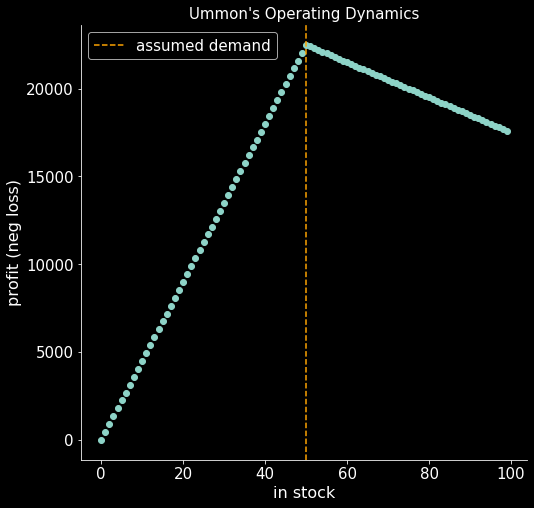

In [10]:
in_stock = np.arange(0, 100)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(in_stock, -loss(in_stock, 50, 50)); ax.axvline(50, c='orange', ls='--', label='assumed demand');
ax.set_xlabel('in stock'); ax.set_ylabel('profit (neg loss)'); ax.set_title("Ummon's Operating Dynamics");
sns.despine(); ax.legend();

Next, we need our estimate of demand. As we have a history of consultant sourcing we have a pretty good idea of what the distribution looks like, but we will also assume that we don't know the true underlying parameters and only have access to the samples.

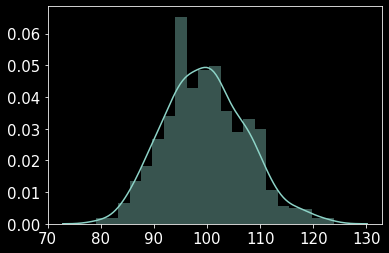

In [11]:
demand_samples = stats.poisson(60, 40).rvs(1000)
sns.distplot(demand_samples);

In response to demand, the loss-function behaves differently: with less demand than what we have in stock, we earn less (because we sell fewer launches but also have to pay holding costs), but as demand exceeds the number of engines we have in stock our profit stays flat because we can't sell more than what we have.

In [12]:
with pm.Model() as model:
    # Priors on alpha and beta parameters for each supplier
    α = pm.HalfNormal('α', sd=10., shape=3)
    β = pm.HalfNormal('β', sd=10., shape=3)
    
    # Different likelihood for every supplier because we have different
    # number of data points
    for i, d in enumerate(data):
        pm.Beta(f'supplier_yield_obs_{i}', 
            alpha=α[i], beta=β[i],
            observed=d)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1981.02draws/s]


## This is a generalizable problem

*  Retailers need to deciding how much to order given yield and holding cost
*  In insurance contracts have to be sold, but there is an underlying risk of becoming claims
*  In online advertising where you need to decide how much to bid on clicks given a budget

>  In general which item should I buy and how much capital should I deploy to each one.

## Generate possible future scenarios

In order to perform Bayesian Decision Making we need an estimate of what the future might look like. As we are in a generative framework this is trivial: we just need to sample from the posterior predictive distribution of our model which generates new data based on our estimated posteriors.

In [13]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, 1000)

/home/adam/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:02<00:00, 405.38it/s]


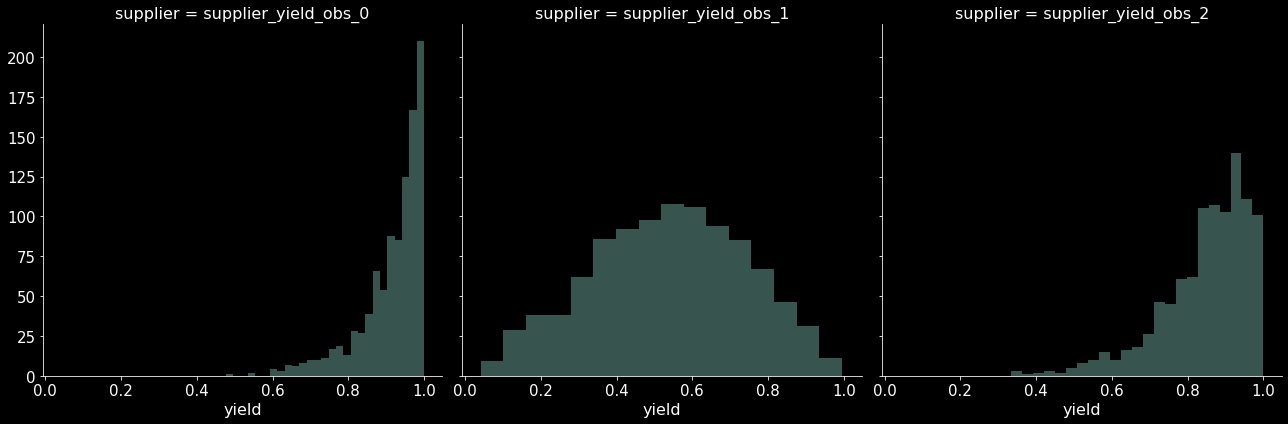

In [14]:
supplier_yield_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})
data_tidy = supplier_yield_post_pred.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier',height=6.0)
g.map(sns.distplot, 'yield', kde=False);

Given the data and our model the previous plot showed what we can expect to observe. Note that these predictions take the uncertainty into account. For supplier 2 we have a lot of uncertainty because we only observed very few data points.

## Resources

* [Video Explaining Bayes Formula](https://www.youtube.com/watch?v=HZGCoVF3YvM)
* [Source Blog Post by Thomas Wiecki](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/supply_chain.ipynb)


## Questions?

<img src="../images/galvanize-mdh.png" alt="galvanize-mdh" align="center" style="width: 200px;"/>

Please direct additional inquiries to pilar@mtydigitalhub.com